# Prototype for false positive suppression function

In [14]:
import numpy as np
from scipy.signal import find_peaks
import seaborn as sns
import matplotlib.pyplot as plt
#TODO - NEGATIVE PEAKS
def fps(signal, min_height, max_height, ratio_range, max_distance, clean_distance):
    
    # Get all peaks
    peak_ixs, peak_props = find_peaks(signal, height=min_height)
    peak_heights = peak_props['peak_heights']
    
    # Compute distance and height ratio to next peak
    peak_dists = peak_ixs[1:] - peak_ixs[:-1]
    peak_ratios = peak_heights[:-1] / peak_heights[1:]
    
    # Peaks in distance
    dist_mask = peak_dists <= max_distance
    
    # Peak observes symmetry ratio
    ratio_mask = np.logical_and(peak_ratios < -1 + ratio_range, peak_ratios > -1 - ratio_range)
    
    # Flag peaks for deletion
    deletion_mask = np.logical_and(dist_mask, ratio_mask)
    
    # Append last tick
    deletion_mask = np.hstack([deletion_mask, 0])
    
    # Remove transients within 'clean_distance' after each flagged peak 
    flagged_peak_ixs = peak_ixs[deletion_mask]
    for fpix in flagged_peak_ixs:
        deletion_mask[fpix:fpix+clean_distance] = 1
        
    # Remove peaks higher than max height
    deletion_mask = np.logical_and(deletion_mask, peak_heights<=max_height)
    
    # Clean signal and return
    peak_heights[deletion_mask] = 0
    return peak_heights

**Plot sample signal**

<Figure size 432x288 with 0 Axes>

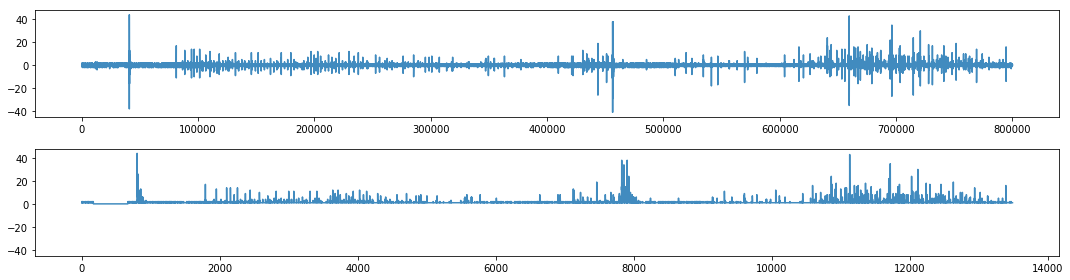

In [15]:
dir_list = [
    '../preprocessed_data/pp_train_db20/pp_train_db20_0.npy',
    '../preprocessed_data/pp_train_db20/pp_train_db20_1.npy',
    '../preprocessed_data/pp_train_db20/pp_train_db20_2.npy',
    '../preprocessed_data/pp_train_db20/pp_train_db20_3.npy',
    '../preprocessed_data/pp_train_db20/pp_train_db20_4.npy',
]
pp_signals = np.vstack([np.load(p) for p in dir_list])

# Selected signal
pp_signal = pp_signals[294, :]

plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 1

f, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15, 4))

for i in np.arange(0,num_signals):
    sampling_freq = 1
    t = np.arange(0, pp_signals.shape[1]/sampling_freq)
    axs[0].plot(t, pp_signal[::sampling_freq], alpha=0.85)
    clean_peaks = fps(
        signal=pp_signal,
        min_height=1,
        max_height=20,
        ratio_range=0.2,
        max_distance=15,
        clean_distance=500,
    )
    t2 = np.arange(0, clean_peaks.size)
    axs[1].plot(t2, clean_peaks, alpha=0.85)
    f.tight_layout()